In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ugradio
import astropy
import os
from matplotlib import colors
from tqdm import tqdm

LT_LAT, LT_LON, LT_ALT = ugradio.leo.lat, ugradio.leo.lon, ugradio.leo.alt

No module named 'rtlsdr'


# Load in Data

In [2]:
# CODE TO LOAD SPECTRA NUMPY FILES IN A DICT

data_dict = {} # dict where key is coordinate (l, b)) and value is [main, noise_on, noise_off, [ra, dec, jd]]
                # where main, noise_on, noise_off are all numpy arrays of the spectra
for filename in tqdm(os.listdir('New_Data/celestial_data/')):
    if filename == ".ipynb_checkpoints" or filename == '.DS_Store':
        continue
        
    split_name = filename.split("_")

    if split_name[0] == 'off':
        fits_type = 2 # off
        save_name = filename[3:]
    elif split_name[0] == 'on':
        fits_type = 1 # on
        save_name = filename[2:]
    else:
        fits_type = 0 # main
        save_name = filename[4:]
    
    
    #l, b, ra, dec, jd
    _, l, b, ra, dec, jd, _ = split_name
    l, b, ra, dec, jd = float(l), float(b), float(ra), float(dec), float(jd) # convert strings to floats

    curr_data = np.mean(np.load('New_Data/celestial_data/' + filename), axis=1) # load the spectra from file
#     curr_data = calc_avg(curr_data) # keep the avg in the dict
    
    if not data_dict.get((l, b)):
        data_dict[(l, b)] = [[], [], [], ra, dec, jd, save_name]      
    data_dict[(l, b)][fits_type] = curr_data[10:-10]
    

for coord in data_dict.keys():
    if not len(data_dict[coord][0]) == len(data_dict[coord][1]) == len(data_dict[coord][2]):
        print("yes", coord)
        new_coord = coord

        
_ = data_dict.pop(new_coord)
        

100%|██████████| 1202/1202 [00:05<00:00, 201.76it/s]

yes (158.8716594064493, 27.0)


In [3]:
# for coord in data_dict.keys():
#     print(coord)

### Clean up trash data

In [3]:
bad_coords = np.load('bad_coords.npy')

print(len(data_dict))
pop_coords = []
for coord in data_dict.keys():
    for i in range(len(bad_coords)):
        if np.isclose(coord[0], bad_coords[i][0], rtol=1e-05) and np.isclose(coord[1], bad_coords[i][1], rtol=1e-05):
            pop_coords.append(coord)

            

for coord in pop_coords:
    data_dict.pop(coord)
print(len(data_dict))

pop_coords = []
for coord in data_dict.keys():
    if coord[1] >= 35:
        pop_coords.append(coord)
        
for coord in pop_coords:
    data_dict.pop(coord)
print(len(data_dict))
        

400
311
231


# Helper Functions

In [4]:
def calc_gain(observation):
    
    """
    A simple function to compute the gain for a given coordinate.
    """    
    data = data_dict[observation]
    
    main_data = data[0]
    on_data = data[1]
    off_data = data[2]
    
    T_NOISE = 90 # Kelvin
    G = (T_NOISE/(np.sum(on_data-off_data))) * np.sum(off_data) #calc Gain
    
    return G


def calc_velocities(observation,ignore_corr=False):
    
    """
    A simple function to calculate the velocities
    """
    
    data = data_dict[observation]
    
    main_data = data[0]
    on_data = data[1]
    off_data = data[2]
    ra = data[3]
    dec = data[4]
    jd = data[5]
    
    FREQ_RES = 8192 
    LO = 1270 #Mhz
    RF = 1420.4058 #Mhz
    c = 3e5 #km/s
    freqs = np.linspace(144,156,FREQ_RES) 
    velocities = (((freqs+LO)-RF)/RF)*c #doppler velocities
    
    if ignore_corr == True:
        correction = 0
    else:
        correction = ugradio.doppler.get_projected_velocity( ra=ra, 
                                                             dec=dec,
                                                             jd=jd,
                                                             obs_lat=LT_LAT,
                                                             obs_lon=LT_LON,
                                                             obs_alt=LT_ALT)


        correction = correction.to(astropy.units.km/astropy.units.s).value

        
    return velocities, correction
    

def calc_peak_max(observation):
    
    """
    A function that takes in 3 observational files and performs
    the calibration to convert to temperature and then returns
    the maximum temperature [K] of that coordinate as well as the 
    corresponding velocity [km/s].
    """
    
    data = data_dict[observation]
    
    main_data = data[0]
    on_data = data[1]
    off_data = data[2]
    
    velocities, correction = calc_velocities(observation)
    
    fitting_indeces = np.where((velocities > -100) & (velocities < 100)) # we zoom in to ignore the ripples
    G = calc_gain(observation)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
    x_data_fit = velocities + correction
    x_data_fit = x_data_fit[fitting_indeces]
    
    vel = x_data_fit[np.argmax(y_data_fit)]
    T = np.max(y_data_fit)
    

    
    
    return T, vel
    
    
    
def get_TV_data(observation):
    data = data_dict[observation]
    
    main_data = data[0]
    on_data = data[1]
    off_data = data[2]
    

    velocities, correction = calc_velocities(observation)
    
    fitting_indeces = np.where((velocities > -100) & (velocities < 100)) # we zoom in to ignore the ripples
    G = calc_gain(observation)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
    y_data_fit[np.where(y_data_fit < 0)] = 0
    x_data_fit = velocities + correction
    x_data_fit = x_data_fit[fitting_indeces]
    
    
    
    return x_data_fit,y_data_fit
    

In [5]:
calc_gain((154.693256659684, 15.0))

206.02231173151165

# More Clean up of this Awful Data

In [6]:
#prepare data for interpolation
Ts = []
Vs = []
for coord in tqdm(data_dict.keys()):
    T,V = calc_peak_max(coord)
    Ts.append(T)
    Vs.append(V)


#prepare data for interpolation
ls, bs, xs, ys = [], [], [], []

for coord in tqdm(data_dict.keys()):
    ls.append(coord[0])
    bs.append(coord[1])
    x,y = get_TV_data(coord)
    xs.append(x)
    ys.append(y)
    
coords = np.array([ls,bs]).T

ls = np.array(ls)
bs = np.array(bs)


#Clean Up Data Dictionary
indices = np.where(np.array(Vs) <= -50)
indices2 = np.where(np.array(Vs) >= 50)
indices = np.append(indices, indices2)

for i in indices:
    coord = (tuple([ls[i], bs[i]]))
    data_dict.pop(coord)
    

#re-prepare data for interpolation after removing bad data
ls, bs, xs, ys = [], [], [], []

for coord in tqdm(data_dict.keys()):
    ls.append(coord[0])
    bs.append(coord[1])
    x,y = get_TV_data(coord)
    xs.append(x)
    ys.append(y)
    
coords = np.array([ls,bs]).T

ls = np.array(ls)
bs = np.array(bs)


100%|██████████| 223/223 [00:32<00:00,  6.81it/s]


# Create Basic Maps

In [7]:
from scipy.interpolate import griddata

Nx, Ny = 500,500
grid_x, grid_y = np.meshgrid(np.linspace(105,160,Nx),
                             np.linspace(15, 50, Ny))

xmin,xmax = 135,160
ymin,ymax = 15,35

grid_temps = griddata(coords, np.array(ys), (grid_x, grid_y), method='linear')
grid_vels = griddata(coords, np.array(xs), (grid_x, grid_y), method='linear')

In [8]:
max_indeces = np.argmax(grid_temps, axis=2)

vel_vals = np.zeros(max_indeces.shape)
for i in range(Nx):
    for j in range(Ny):
        vel_vals[i,j] = grid_vels[i,j][max_indeces[i,j]]

In [11]:
mpl.rcParams['axes.linewidth'] = 3 #set the value globally
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

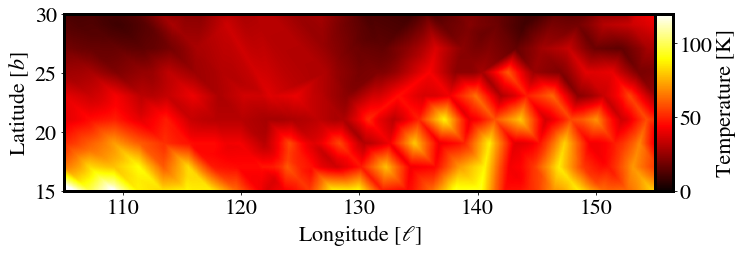

In [12]:
colors=[(1, 1, 1, 1) for _ in ls]       
f, axes = plt.subplots(1,1, figsize=(16,4))

im1 = axes.imshow(np.max(grid_temps, axis=2), extent=[105,160,15, 50],
               origin="lower",cmap="hot", vmin=0, vmax=120)
# axes.scatter(ls, bs, facecolor=colors,edgecolor="black",linewidth=0.5,alpha=0.5,s=600, marker="h")

axes.set_ylim(15,30)
axes.set_xlim(105,155)
axes.set_xlabel("Longitude [$\\ell$]")
axes.set_ylabel("Latitude [$b$]")

plt.colorbar(im1, pad=0, aspect=10, label="Temperature [K]")
plt.tight_layout()
# plt.savefig("TempMap.pdf", dpi=300, bbox_inches="tight")
plt.show()

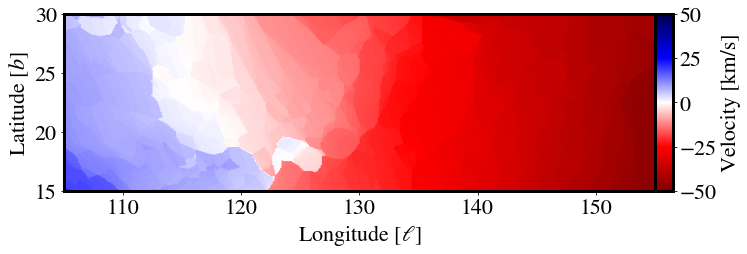

In [13]:
colors=[(1, 1, 1, 1) for _ in ls]

f, axes = plt.subplots(1,1, figsize=(16,4))
im2 = axes.imshow(vel_vals, extent=[105,160,15, 50],
               origin="lower",
                aspect="equal",cmap="seismic_r",
                vmin=-50, vmax=50)

# axes.scatter(ls, bs, facecolor=colors,edgecolor="black",linewidth=0.5,alpha=0.5,s=600, marker="h")

axes.set_ylim(15,30)
axes.set_xlim(105,155)
axes.set_xlabel("Longitude [$\\ell$]")
axes.set_ylabel("Latitude [$b$]")

plt.colorbar(im2, pad=0, aspect=10, label="Velocity [km/s]")
plt.tight_layout()
# plt.savefig("VelocityMap.pdf", dpi=300, bbox_inches="tight")
plt.show()




# Column Density Stuff



### Gaussian Fitting Function & Mass Calculation

In [14]:
def calc_peak_gaussian(observation):
    
    """
    A function to compute the Temperature [K] and Velocity [km/s] 
    at the peak using a gaussian fit.
    """
    
    data = data_dict[observation]
    
    main_data = data[0]
    on_data = data[1]
    off_data = data[2]
    
    velocities,correction = calc_velocities(observation)
    
    fitting_indeces = np.where((velocities > -100) & (velocities < 100)) # we zoom in to ignore the ripples
    G = calc_gain(observation)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
#     y_data_fit[np.where(y_data_fit < 0)] = 0
    x_data_fit = velocities + correction
    x_data_fit = x_data_fit[fitting_indeces]
    
    ######################################################################
    
    err = 10
    

    fit_params_single = ugradio.gauss.gaussfit(x_data_fit, 
                                        y_data_fit, 
                                        amp=np.max(y_data_fit),
                                        avg=x_data_fit[np.argmax(y_data_fit)],
                                        sig=10) #get fit
    
    
    
    chisq_r_s_single = (np.sum(np.abs(y_data_fit - 
                                   ugradio.gauss.gaussval(x_data_fit, **fit_params_single))**2)
                                 / (y_data_fit.size - 3) / err**2)
    
    ######################################################################
    
    fit_params_double = ugradio.gauss.gaussfit(x_data_fit, 
                                        y_data_fit, 
                                        amp=[np.max(y_data_fit),np.max(y_data_fit)/2] ,
                                        avg=[x_data_fit[np.argmax(y_data_fit)],x_data_fit[np.argmax(y_data_fit)]/2],
                                        sig=[10, 10]) #get fit
    
    
    
    chisq_r_s_double = (np.sum(np.abs(y_data_fit - 
                           ugradio.gauss.gaussval(x_data_fit, **fit_params_double))**2)
                         / (y_data_fit.size - 3) / err**2)
    
    
    ######################################################################
    
    if chisq_r_s_double < chisq_r_s_single:
#         print(f"returning double with χ^2_r double {chisq_r_s_double:0.3f} < χ^2_r single {chisq_r_s_single:0.3f}")
        
        amps = fit_params_double["amp"]
        if amps[0] < 0 or amps[1] < 0:
            i = np.where(amps < 0)[0][0]
        
            for key in fit_params_double.keys():
                fit_params_double[key] = np.delete(fit_params_double[key], i)
                
                
            fit_params_double["status"] = "single"
        else:
            fit_params_double["status"] = "double"

        return fit_params_double
    else:
#         print(f"returning single with χ^2_r double {chisq_r_s_double:0.3f} > χ^2_r single {chisq_r_s_single:0.3f}")
        fit_params_single["status"] = "single"
        return fit_params_single

    
    

    
#     T, vel, sigma = fit_params['amp'][0], fit_params['avg'][0], fit_params['sig'][0]
                 
#     return None


def calc_mass(observation, params, errors):
    """
    A function that calculates the expected mass along a line of sight.
    """
    
    
    Ω_beam = 2 * (np.pi/180)**2 #to stradians
    m_H = ((astropy.constants.m_p + astropy.constants.m_p).to(astropy.units.g)).value
    d = ((100 * astropy.units.pc).to(astropy.units.cm)).value
    
    C =  (1.8e18 * m_H * d**2 * Ω_beam)

    #single peak case
    if len(errors) == 3 and errors.shape != (3,2):
        if fit_params['status'] != "single":
            raise AssertionError("Fit params not matching errors!")
        else:
            T = fit_params['amp'][0]
            δT = errors[0]
            
            σ_v = fit_params['sig'][0]
            σ_v = (np.abs(σ_v * astropy.units.km/astropy.units.s).to(astropy.units.cm / astropy.units.s)).value 
            δv = errors[2]
            δv = (np.abs(δv * astropy.units.km/astropy.units.s).to(astropy.units.cm / astropy.units.s)).value
            
            M = (C * σ_v * T) * astropy.units.g
            δM = C * np.sqrt((σ_v**2 * δT**2) + (T**2 * δv**2)) * astropy.units.g
            
        
    elif errors.shape == (3,2):
        if fit_params['status'] != "double":
            raise AssertionError("Fit params not matching errors!")
        else:
            T_1 = fit_params['amp'][0]
            T_2 = fit_params['amp'][1]
            
            δT_1 = errors[0,0] 
            δT_2 = errors[0,1] 
            
            σ_v_1 = fit_params['sig'][0]
            σ_v_2 = fit_params['sig'][1]
            
            σ_v_1 = (np.abs(σ_v_1 * astropy.units.km/astropy.units.s).to(astropy.units.cm / astropy.units.s)).value 
            σ_v_2 = (np.abs(σ_v_2 * astropy.units.km/astropy.units.s).to(astropy.units.cm / astropy.units.s)).value 

            δv_1 = errors[2,0]
            δv_2 = errors[2,0]
            
            δv_1 = (np.abs(δv_1 * astropy.units.km/astropy.units.s).to(astropy.units.cm / astropy.units.s)).value
            δv_2 = (np.abs(δv_2 * astropy.units.km/astropy.units.s).to(astropy.units.cm / astropy.units.s)).value


            M_1 = (C * σ_v_1 * T_1) * astropy.units.g
            δM_1 = C * np.sqrt((σ_v_1**2 * δT_1**2) + (T_1**2 * δv_1**2)) * astropy.units.g
            
            M_2 = (C * σ_v_2 * T_2) * astropy.units.g
            δM_2 = C * np.sqrt((σ_v_2**2 * δT_2**2) + (T_2**2 * δv_2**2)) * astropy.units.g
            
            M = M_1 + M_2
            δM = np.sqrt(δM_1**2 + δM_2**2)
    

    return M.to(astropy.units.solMass).value, δM.to(astropy.units.solMass).value



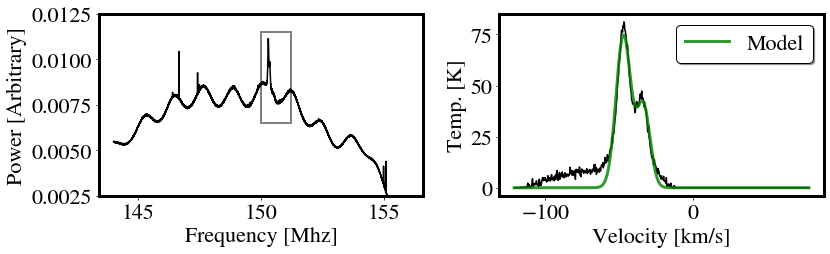

In [79]:
f, axes = plt.subplots(1,2, figsize=(12,4))




for i, coord in enumerate(data_dict.keys()):
    
    if i == 3:
        fit_params = calc_peak_gaussian(coord)
#         print(fit_params)

        xs,ys = get_TV_data(coord)

        y_fit = ugradio.gauss.gaussval(xs, fit_params['amp'],fit_params['avg'],fit_params['sig'])
        
    
        FREQ_RES = 8192
        LO = 1270 #Mhz
        RF = 1420.4058 #Mhz
        c = 3e5 #km/s
        freqs = np.linspace(144,156,FREQ_RES)[10:-10]
        
        axes[0].plot(freqs,data_dict[coord][0], color="black", label="Data")
        axes[0].set_xlabel("Frequency [Mhz]")
        axes[0].set_ylabel("Power [Arbitrary]")
        axes[0].set_ylim(0.0025,0.0125)
#         axes[0].legend(loc="lower left", edgecolor="black", shadow=True)


        
#         draw a rectangle (xy is bottom left corner coordinate)
        rect = patches.Rectangle(xy=(150,0.0065), width=1.2, height=0.005, edgecolor='grey',linewidth=2, facecolor='white')
        axes[0].add_artist(rect)
        
#         zoom_outside(axes[0], [150, 0.0065, 150 + 1.2, 0.0065 + 0.005], axes[1], "black")
        
        axes[1].plot(xs,ys, color="black")
        axes[1].plot(xs,y_fit, color="green", alpha=0.8, linewidth=3, label="Model")
        axes[1].legend(edgecolor="black", shadow=True)
        axes[1].set_xlabel("Velocity [km/s]")
        axes[1].set_ylabel("Temp. [K]")
        plt.tight_layout()
        plt.savefig("process.pdf", dpi=300, bbox_inches="tight")
        





### Perform Error Analysis of Fits

In [80]:
def get_errors_on_fit(xs,ys,err,nσ, fit_params_on,verbose=True):
    

    σ = err
    
    def give_errors(chis, nσ):

            for i in range(3):
                for j in range(2):
                    upper_bound = np.max([np.where(chis <= nσ**2)])
                    lower_bound = np.min([np.where(chis <= nσ**2)])
                    errors = [int(lower_bound), int(upper_bound)]

            return errors
    
    if fit_params_on["status"] == "single":
        
        # ---------------------------------------------------------------------------------------------
        
        chisq = []
        amp_1 = np.linspace(fit_params_on['amp'][0] - 100, fit_params_on['amp'][0] + 100, 1000)

        for i in range(1000):
            chisq.append(np.sum(np.abs(ys - 
                                       ugradio.gauss.gaussval(xs,
                                                              [amp_1[i]],
                                                              fit_params_on['avg'],
                                                              fit_params_on['sig']))**2) / σ**2)

        chisq = np.array(chisq)

        chisq_amp_1 = chisq - np.min(chisq)


        # ---------------------------------------------------------------------------------------------

        chisq = []
        avg_1 = np.linspace(fit_params_on['avg'][0] - 10, fit_params_on['avg'][0] + 10, 1000)

        for i in range(1000):
            chisq.append(np.sum(np.abs(ys - 
                                       ugradio.gauss.gaussval(xs,
                                                              fit_params_on['amp'],
                                                              [avg_1[i]],
                                                              fit_params_on['sig']))**2) / σ**2)

        chisq = np.array(chisq)

        chisq_avg_1 = chisq - np.min(chisq)


        # ---------------------------------------------------------------------------------------------

        chisq = []
        sig_1 = np.linspace(fit_params_on['sig'][0] - 10, fit_params_on['sig'][0] + 10, 1000)

        for i in range(1000):
            chisq.append(np.sum(np.abs(ys - 
                                       ugradio.gauss.gaussval(xs,
                                                              fit_params_on['amp'],
                                                              fit_params_on['avg'],
                                                              [sig_1[i]]))**2) / σ**2)

        chisq = np.array(chisq)

        chisq_sig_1 = chisq - np.min(chisq)

        params = np.array([amp_1, avg_1, sig_1])
        names = np.array(["Peak Temperature [K]",
                         "Peak Velocity [km/s]",
                         "Peak Std [km/s]"])
        
        # ---------------------------------------------------------------------------------------------
        
        chis = np.array([chisq_amp_1,  chisq_avg_1,  chisq_sig_1])


        
        final_errors = np.zeros((3,2))
        for i in range(3):
            errors = give_errors(chis[i], nσ)
            upper_bound = errors[1]
            lower_bound = errors[0]
            final_errors[i] = [params[i][lower_bound] - params[i][np.argmin(chis[i])],
                                 params[i][upper_bound] - params[i][np.argmin(chis[i])]]



        final_errors = np.mean(np.abs(final_errors), axis=1)

        if verbose == True:
            for i in range(3):
                print("\nWe find", names[i], "to be {0:0.2f} +\- {1:0.2f}".format(
                                                                                params[i][np.argmin(chis[i])], 
                                                                                final_errors[i]))


    elif fit_params_on["status"] == "double":
        
        # ---------------------------------------------------------------------------------------------
        
        chisq = []
        amp_1 = np.linspace(fit_params_on['amp'][0] - 100, fit_params_on['amp'][0] + 100, 1000)

        for i in range(1000):
            chisq.append(np.sum(np.abs(ys - 
                                       ugradio.gauss.gaussval(xs,
                                                              [amp_1[i],fit_params_on['amp'][1]],
                                                              fit_params_on['avg'],
                                                              fit_params_on['sig']))**2) / σ**2)

        chisq = np.array(chisq)

        chisq_amp_1 = chisq - np.min(chisq)


        chisq = []
        amp_2 = np.linspace(fit_params_on['amp'][1] - 100, fit_params_on['amp'][1] + 100, 1000)
        for i in range(1000):
            chisq.append(np.sum(np.abs(ys - 
                                       ugradio.gauss.gaussval(xs,
                                                              [fit_params_on['amp'][0],amp_2[i]],
                                                              fit_params_on['avg'],
                                                              fit_params_on['sig']))**2) / σ**2)

        chisq = np.array(chisq)

        chisq_amp_2 = chisq - np.min(chisq)

        # ---------------------------------------------------------------------------------------------

        chisq = []
        avg_1 = np.linspace(fit_params_on['avg'][0] - 10, fit_params_on['avg'][0] + 10, 1000)

        for i in range(1000):
            chisq.append(np.sum(np.abs(ys - 
                                       ugradio.gauss.gaussval(xs,
                                                              fit_params_on['amp'],
                                                              [avg_1[i], fit_params_on['avg'][1]],
                                                              fit_params_on['sig']))**2) / σ**2)

        chisq = np.array(chisq)

        chisq_avg_1 = chisq - np.min(chisq)


        chisq = []
        avg_2 = np.linspace(fit_params_on['avg'][1] - 10, fit_params_on['avg'][1] + 10, 1000)
        for i in range(1000):
            chisq.append(np.sum(np.abs(ys - 
                                       ugradio.gauss.gaussval(xs,
                                                              fit_params_on['amp'],
                                                              [fit_params_on['avg'][0],avg_2[i]],
                                                              fit_params_on['sig']))**2) / σ**2)

        chisq = np.array(chisq)

        chisq_avg_2 = chisq - np.min(chisq)

        # ---------------------------------------------------------------------------------------------

        chisq = []
        sig_1 = np.linspace(fit_params_on['sig'][0] - 10, fit_params_on['sig'][0] + 10, 1000)

        for i in range(1000):
            chisq.append(np.sum(np.abs(ys - 
                                       ugradio.gauss.gaussval(xs,
                                                              fit_params_on['amp'],
                                                              fit_params_on['avg'],
                                                              [sig_1[i], fit_params_on['sig'][1]]))**2) / σ**2)

        chisq = np.array(chisq)

        chisq_sig_1 = chisq - np.min(chisq)


        chisq = []
        sig_2 = np.linspace(fit_params_on['sig'][1] - 10, fit_params_on['sig'][1] + 10, 1000)
        for i in range(1000):
            chisq.append(np.sum(np.abs(ys - 
                                       ugradio.gauss.gaussval(xs,
                                                              fit_params_on['amp'],
                                                              fit_params_on['avg'],
                                                              [fit_params_on['sig'][0], sig_2[i]]))**2) / σ**2)

        chisq = np.array(chisq)

        chisq_sig_2 = chisq - np.min(chisq)
        
        # ---------------------------------------------------------------------------------------------
        
        params = np.array([amp_1, amp_2, avg_1, avg_2, sig_1, sig_2]).reshape(3,2,-1)
        names = np.array(["1st Peak Temperature [K]", "2nd Peak Temperature [K]",
                 "1st Peak Velocity [km/s]", "2nd Peak Velocity [km/s]",
                 "1st Peak Std [km/s]", "2nd Peak Std [km/s]"]).reshape(3,2)
        chis = np.array([chisq_amp_1, chisq_amp_2, chisq_avg_1, chisq_avg_2, chisq_sig_1, chisq_sig_2]).reshape(3,2,-1)


        final_errors = np.zeros((3,2,2))
        for i in range(3):
            for j in range(2):
                errors = give_errors(chis[i,j], nσ)
                upper_bound = errors[1]
                lower_bound = errors[0]
                final_errors[i,j] = [params[i, j][lower_bound] - params[i, j][np.argmin(chis[i, j])],
                                     params[i, j][upper_bound] - params[i, j][np.argmin(chis[i, j])]]



        final_errors = np.mean(np.abs(final_errors), axis=2)

        if verbose == True:
            for i in range(3):
                for j in range(2):
                    print(i,j)
                    print("\nWe find", names[i,j], "to be {0:0.2f} +\- {1:0.2f}".format(
                                                                                params[i, j][np.argmin(chis[i, j])], 
                                                                                final_errors[i,j]))



        
    else:
        print("That didn't work... Couldn't determine status. (Must be 'single' or 'double')")
        
        
    if len(final_errors) == 3 and final_errors.shape != (3,2):
        if fit_params_on['status'] != "single":
            raise AssertionError("Fit params not matching errors!")
#         print("Shape Single Works")
        
    elif final_errors.shape == (3,2):
        if fit_params_on['status'] != "double":
            raise AssertionError("Fit params not matching errors!")
#         print("Shape Double Works")

    return final_errors

        


### Mass Calculation

In [81]:
M_total = 0
δM_total = 0

i = 0

Ms,ls,bs = [],[],[]
for coord in tqdm(data_dict.keys()):
#     print("\n", i, "\n")
    try:
        xs,ys = get_TV_data(coord)
        fit_params = calc_peak_gaussian(coord)
        errors = get_errors_on_fit(xs,ys,10,2, fit_params, verbose=False)

        M,δM = calc_mass(coord, fit_params, errors)

        M_total += M
        δM_total += δM**2
        
        Ms.append(M)
        ls.append(coord[0])
        bs.append(coord[1])
        
    except:
        print("Failed a Fitting.")
        
    i += 1
    
#     if i > 5:
#         break
    

    
coords = np.array([ls,bs]).T


        

δM_total = np.sqrt(δM_total)


print(f"M = {M_total:0.3e} +/- {δM_total:0.3e} Solar Masses")

  2%|▏         | 4/223 [00:03<03:47,  1.04s/it]/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  6%|▌         | 13/223 [00:11<02:46,  1.26it/s]

Failed a Fitting.


 41%|████▏     | 92/223 [01:27<01:41,  1.29it/s]

Failed a Fitting.


 50%|█████     | 112/223 [01:48<01:54,  1.03s/it]

Failed a Fitting.


 54%|█████▍    | 121/223 [01:56<01:24,  1.21it/s]

Failed a Fitting.


 59%|█████▉    | 132/223 [02:06<01:15,  1.20it/s]

Failed a Fitting.


 75%|███████▍  | 167/223 [02:38<00:44,  1.26it/s]

Failed a Fitting.


 83%|████████▎ | 185/223 [02:56<00:31,  1.21it/s]

Failed a Fitting.


 83%|████████▎ | 186/223 [02:56<00:26,  1.38it/s]

Failed a Fitting.


100%|██████████| 223/223 [03:35<00:00,  1.04it/s]

M = 5.832e+09 +/- 1.225e+09 Solar Masses


In [82]:
ls_copy = np.array(ls)
bs_copy = np.array(bs)
Ms_copy = np.array(Ms)

is_ = []
for i in range(len(ls)):
    if Ms[i] > 1e8:
        is_.append(i)
        
        
Ms_copy = np.delete(Ms_copy, is_)
ls_copy = np.delete(ls_copy, is_)
bs_copy = np.delete(bs_copy, is_)


coords = np.array([ls_copy,bs_copy]).T

### Final Data Cleanse

In [83]:
# These were the really bad fits! Let's Remove em

print(len(data_dict))
for i in range(len(is_)):
    coord = (ls[is_[i]], bs[is_[i]])
    data_dict.pop(coord)
    
    
print(len(data_dict))    
    


223
220


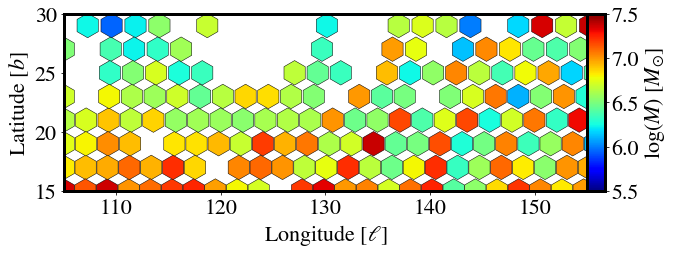

In [84]:
colors=[(1, 1, 1, 1) for _ in ls]

f, axes = plt.subplots(1,1, figsize=(10,4))

# im1 = axes.imshow(grid_mass_, extent=[105,160,15, 50], 
#                   origin="lower",cmap="jet",vmin=6, vmax=9)
im1 = axes.scatter(ls_copy, bs_copy, c=np.log10(Ms_copy), cmap="jet",
                   edgecolor="black",linewidth=0.5,alpha=1,s=600, marker="h",vmin=5.5, vmax=7.5)

axes.set_ylim(15,30)
axes.set_xlim(105,155)
axes.set_xlabel("Longitude [$\\ell$]")
axes.set_ylabel("Latitude [$b$]")

plt.colorbar(im1, pad=0, aspect=10, label="$\log(M)$ [$M_{\odot}$]")
plt.tight_layout()
# plt.savefig("TempMap.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [85]:
M_total = 0
δM_total = 0

i = 0

Ms,δMs, ls,bs = [],[],[], []
for coord in tqdm(data_dict.keys()):
#     print("\n", i, "\n")
    try:
        xs,ys = get_TV_data(coord)
        fit_params = calc_peak_gaussian(coord)
        errors = get_errors_on_fit(xs,ys,10,2, fit_params, verbose=False)

        M,δM = calc_mass(coord, fit_params, errors)

        M_total += M
        δM_total += δM**2
        
        Ms.append(M)
        δMs.append(δM)
        ls.append(coord[0])
        bs.append(coord[1])
        
    except:
        print("Failed a Fitting.")
        
    i += 1
    
    
coords = np.array([ls,bs]).T

δM_total = np.sqrt(δM_total)

print(f"M = {M_total:0.3e} +/- {δM_total:0.3e} Solar Masses")

  6%|▌         | 13/220 [00:11<02:47,  1.24it/s]

Failed a Fitting.


 40%|████      | 89/220 [01:25<01:41,  1.29it/s]

Failed a Fitting.


 50%|████▉     | 109/220 [01:46<01:55,  1.04s/it]

Failed a Fitting.


 54%|█████▎    | 118/220 [01:54<01:24,  1.20it/s]

Failed a Fitting.


 59%|█████▊    | 129/220 [02:04<01:15,  1.20it/s]

Failed a Fitting.


 75%|███████▍  | 164/220 [02:37<00:44,  1.26it/s]

Failed a Fitting.


 83%|████████▎ | 182/220 [02:54<00:31,  1.20it/s]

Failed a Fitting.


 83%|████████▎ | 183/220 [02:55<00:26,  1.37it/s]

Failed a Fitting.


100%|██████████| 220/220 [03:33<00:00,  1.03it/s]

M = 1.426e+09 +/- 3.172e+07 Solar Masses


## Mass Map

In [86]:
# UNCOMMENT BELOW TO LOOK AT ALL FITS!

# for i, coord in enumerate(data_dict.keys()):
#     try:
#         fit_params = calc_peak_gaussian(coord)
#         xs,ys = get_TV_data(coord)

#         y_fit = ugradio.gauss.gaussval(xs, fit_params['amp'],fit_params['avg'],fit_params['sig'])

#         plt.figure()
#         plt.plot(xs,ys, color="black")
#         plt.plot(xs,y_fit, color="orangered", linewidth=3)
#         plt.show()

#     except:
#         print("that shit failed.")


In [88]:
from scipy.interpolate import griddata

Nx, Ny = 500,500

grid_x, grid_y = np.meshgrid(np.linspace(105,160,Nx),
                             np.linspace(15, 50, Ny))

xmin,xmax = 105,160
ymin,ymax = 15,35

grid_mass = griddata(coords, np.log10(Ms_copy), (grid_x, grid_y), method='cubic')


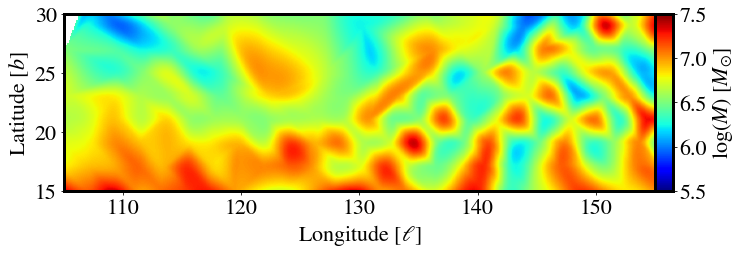

In [90]:
colors=[(1, 1, 1, 1) for _ in ls]

f, axes = plt.subplots(1,1, figsize=(16,4))

im1 = axes.imshow(grid_mass, extent=[105,160,15, 50], 
                  origin="lower",cmap="jet",vmin=5.5, vmax=7.5)
# axes.scatter(ls, bs, facecolor=colors,edgecolor="black",linewidth=0.5,alpha=0.5,s=600, marker="h")

axes.set_ylim(15,30)
axes.set_xlim(105,155)
axes.set_xlabel("Longitude [$\\ell$]")
axes.set_ylabel("Latitude [$b$]")

plt.colorbar(im1, pad=0, aspect=10, label="$\log(M)$ [$M_{\odot}$]")
plt.tight_layout()
# plt.savefig("MassMap.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [91]:
# for coord in data_dict.keys():
#     if coord[0] > 130 and coord[0] < 134 and coord[1] > 25 and coord[1] < 30:
#         print(coord)
        

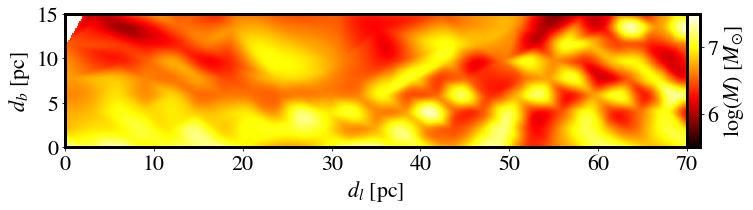

In [99]:
Δθ_l = np.deg2rad(xmax - xmin)
Δθ_b = np.deg2rad(ymax - ymin)

d_l = np.arctan(Δθ_l) * 100
d_b = np.arctan(Δθ_b) * 100

f, axes = plt.subplots(1,1, figsize=(12,3))

im1 = axes.imshow(grid_mass, extent=[0,d_l,0, d_b], 
                  origin="lower",cmap="hot",vmin=5.5, vmax=7.5)
# axes.scatter(ls, bs, facecolor=colors,edgecolor="black",linewidth=0.5,alpha=0.5,s=600, marker="h")


axes.set_xlim(0, 70)
axes.set_ylim(0, 15)
axes.set_xlabel("$d_l$ [pc]")
axes.set_ylabel("$d_b$ [pc]")

plt.colorbar(im1, pad=0, aspect=10, label="$\log(M)$ [$M_{\odot}$]")
plt.tight_layout()
# plt.savefig("TempMap.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [87]:
# from scipy.interpolate import griddata

# Nx, Ny = 500,500

# grid_x, grid_y = np.meshgrid(np.linspace(105,160,Nx),
#                              np.linspace(15, 50, Ny))

# xmin,xmax = 105,160
# ymin,ymax = 15,35

# grid_chis = griddata(coords, χs, (grid_x, grid_y), method='linear')

# f, axes = plt.subplots(1,1, figsize=(16,4))

# im1 = axes.imshow(grid_chis, extent=[105,160,15, 50], 
#                   origin="lower",cmap="hot",vmin=0.5, vmax=3)
# # axes.scatter(ls, bs, facecolor=colors,edgecolor="black",linewidth=0.5,alpha=0.5,s=600, marker="h")

# axes.set_ylim(15,30)
# axes.set_xlim(105,155)
# axes.set_xlabel("Longitude [$\\ell$]")
# axes.set_ylabel("Latitude [$b$]")

# plt.colorbar(im1, pad=0, aspect=10, label="$\\chi^2_r$")
# plt.tight_layout()
# # plt.savefig("TempMap.pdf", dpi=300, bbox_inches="tight")
# plt.show()